## Information Planning

Information planning involves making decisions based on information measures. Information planning is closely related to active learning [1] and optimum experiment design [2] in which labeled data is expensive to obtain. The key idea behind active learning is that a model can learn better with fewer labeled examples if the training examples are carefully selected to maximize the information gain for a particular task. In other words, given an abundance of unlabelled data, we would like to rank the unlabelled examples according to their usefullness to training of the model. The top-K most useful training examples are labelled by expert annotators and are added to the training set.

Here, we'll consider the task of text classification using a Naive Bayes graphical model. We'll look at two information measures [3]: entropy and mutual information that will be used to rank unlabelled set of documents for information planning.

<img src="figures/naive_bayes_gm.png">

Let $x_{i,j}$ be Bernoulli random variables indicating the presence ($x_{ij} = 1$) or absence ($x_{ij}=0$) of a word $j \in \{1,...,D\}$ for document $i \in \{1,...,n\}$, parameterized by $\theta_{jc}$ for a given class label $y = c \in \{1,...,C\}$. In addition, let $\pi$ be a Dirichlet distirbution representing the prior over the class labels. Thus, the total number of learnable parameters is $|\theta| + |\pi| = O(DC) + O(C) = O(DC)$, where $D$ is the dictionary size and $C$ is the number of classes. Due to the small number of parameters, the Naive Bayes model is immune to over-fitting.

**The choice of Bernoulli Naive Bayes formulation is important because it leads itself to word-based information planning. By associating each word in the dictionary with a binary random variable, we are able to compute the influence of individual words on class label distribution.**

We can write-down the class conditional density as follows:

\begin{equation}
    p(x|y=c, \theta) = \prod_{i=1}^{n} \prod_{j=1}^{D} p(x_{ij}|y=c, \theta_{jc}) = \prod_{i=1}^{n} \prod_{j=1}^{D} \mathrm{Bernoulli}(\theta_{jc})
\end{equation}

We can derive the Naive Bayes inference algorithm by maximizing the log-likelihood. Consider words $x_i$ in a single document $i$:

\begin{equation}
    p(x_i, y_i|\theta) = p(y_i|\pi)\prod_{j=1}^{D}p(x_{ij}|y_i, \theta) = \prod_{c=1}^{C}\pi_{c}^{1[y_i=c]}\prod_{j=1}^{D}\prod_{c=1}^{C}p(x_{ij}|\theta_{jc})^{1[y_i=c]}
\end{equation}


Using the Naive Bayes assumption, we can compute the log-likelihood objective:

\begin{equation}
\log p(D|\theta) = \log \prod_{i=1}^{n} p(x_i,y_i|\theta) = \sum_{i=1}^{n}\log p(x_i,y_i|\theta)
= \sum_{c=1}^{C}N_c \log \pi_c + \sum_{j=1}^{D}\sum_{c=1}^{C}\sum_{i:y_i = c} \log p(x_{ij}|\theta_{jc})
\end{equation}

By setting the gradient of $\log p(D|\theta)$ with respect to the model parameters $\pi_c$ and $\theta_{jc}$ to zero, we obtain the following MLE updates: $\hat{\pi_c} = \frac{N_c}{N}$ and $\hat{\theta_{jc}} = \frac{N_{jc}}{N_c}$ where $N_c = \sum_{i=1}^{n} 1[y_i = c]$. Note, that it's straight forward to add a Beta prior for the Bernoulli random variables and a Dirichlet prior for the class density to smooth the MLE counts:

\begin{eqnarray}
    p(\pi|D) &=& \mathrm{Dir}(N_1+\alpha_1, ..., N_c + \alpha_c) \\
    p(\theta_{jc}|D) &=& \mathrm{Beta}([N_c-N_{jc}] + \beta_0, N_{jc} + \beta_1)    
\end{eqnarray}

During test time, we would like to predict the class label $y$ given the training data $D$ and the learned model parameters. Applying the Bayes rule:

\begin{equation}
    p(y=c|x_{i,1},...,x_{i,D},D) \propto p(y=c|D) p(x_{i,1},...,x_{i,D}|y=c, D) = p(y=c|D) \prod_{j=1}^{D}p(x_{ij}|y=c,D)
\end{equation}

Substituting the distributions for $p(y=c|D)$ and $p(x_{ij}|y=c,D)$ and taking the log, we get:

\begin{equation}
    \log p(y=c|x,D) \propto \log p(y=c|D) + \sum_{j=1}^{D}\bigg(1[x_{ij}=1]\log \theta_{jc} + 1[x_{ij}=0]\log(1-\theta_{jc}) \bigg)
\end{equation}

The Baeysian formulation of Bernoulli Naive Bayes is implemented in scikit-learn [5] using the steps outlined above. While it's really good practice to derive and implement ML algorithms from scratch (and in faster languages such as C++), we'll use the scikit-learn implementation and focus on information planning. Let's start by importing the required libraries.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from scipy.misc import logsumexp
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

sns.set_style("whitegrid")
np.random.seed(0)

tokenizer = RegexpTokenizer(r'\w+')
stop = set(stopwords.words('english'))

We will train our model on a subset of the 20newsgroups dataset. In particular, we'll restrict ourselves to $4$ classes: space, graphics, autos, and hockey.

In [3]:
#load data
print "loading 20 newsgroups dataset..."
tic = time()
classes = ['sci.space', 'comp.graphics', 'rec.autos', 'rec.sport.hockey']
dataset = fetch_20newsgroups(shuffle=True, random_state=0, remove=('headers','footers','quotes'), categories=classes)
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.5, random_state=0)
toc = time()
print "elapsed time: %.4f sec" %(toc - tic)    
print "number of training docs: ", len(X_train)
print "number of test docs: ", len(X_test)

loading 20 newsgroups dataset...
elapsed time: 5.9363 sec
number of training docs:  1185
number of test docs:  1186


We'll use a count vectorizer to produce a vector of word counts for each document while filtering stop and low-frequency words.

In [5]:
tic = time()
cnt_vec = CountVectorizer(tokenizer=tokenizer.tokenize, analyzer='word', ngram_range=(1,1), max_df=0.8, min_df=2, max_features=1000, stop_words='english')
cnt_vec.fit(X_train)
toc = time()
print "elapsed time: %.2f sec" %(toc - tic)
vocab = cnt_vec.vocabulary_
idx2word = {val: key for (key, val) in vocab.items()}
print "vocab size: ", len(vocab)

X_train_vec = cnt_vec.transform(X_train) #size [D, V]
X_test_vec = cnt_vec.transform(X_test)

elapsed time: 0.28 sec
vocab size:  1000


Let's execute the Naive Bayes inference described earlier and use the trained model to predict class labels on test data.

In [7]:
print "naive bayes model MAP inference..."
nb_clf = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True)
nb_clf.fit(X_train_vec, y_train)

y_pred = nb_clf.predict(X_test_vec)
nb_clf_acc = accuracy_score(y_test, y_pred)
print "test set accuracy: ", nb_clf_acc


naive bayes model MAP inference...
test set accuracy:  0.701517706577


### Entropy Planning

Entropy measures the amount of uncertainty in a random variable. In entropy based planning, we want to rank test-documents according to the entropy of their class label. The idea is that by annotating documents that have highest uncertainty about their class label will be able to better train our model with fewer annotated examples. In the case of the class distribution, the entropy can be computed in closed form: $H(y) = -\sum_{c=1}^{C} p(y=c) \log p(y=c)$

In [10]:
#rank test documents according to entropy of their class label
top_K = 20
X_test_class_logp = nb_clf.predict_log_proba(X_test_vec)
X_test_class_entropy = -np.sum(np.exp(X_test_class_logp) * X_test_class_logp, axis=1)
planning_entropy_idx = np.argsort(X_test_class_entropy)[-top_K:]

### Mutual Information Planning

In the case of mutual information, we need to choose the random variables we want to use for planning. We want to be able to rank documents given observed test data and learned model parameters. In this case, we consider estimating $I(x_j;y)$, the mutual information between a Bernoulli word indicator $x_j$ and the document label $y$, i.e. we are interested in measuring the information gain about the class label given observed words $x_j$ in a test document. Since both variables are discrete, the mutual information can be estimated in closed form:

\begin{equation}
    I(x_j; y) = \mathrm{KL}\bigg(p(x_j,y)~||~p(x_j)p(y)\bigg) = \sum_{x \in \{0,1\}} \sum_{y\in C} p(x_j,y)\log \frac{p(x_j,y)}{p(x_j)p(y)} = \sum_{x \in \{0,1\}} \sum_{y \in C} p(x_j|y)p(y)\log \frac{p(x_j|y)}{p(x_j)}
\end{equation}

we can compute $p(x_j)$ using the law of total probability: $p(x_j) = \sum_{c \in C}p(x_j=1|y=c)p(y=c)$, and we already know the class conditional $p(x_j|y) = \mathrm{Bernoulli}(\theta_{jc})$ and the marginal $p(y) = \mathrm{Dirichlet}(\pi)$. We are intersted in evaluating mutual information for the *entire* test document. Given our bag of words model, we can compute $I(x_{doc};y)$ by summing over MI terms for every word in the document as follows:

\begin{equation}
    I(x_{doc};y) = I(x_{1},...,x_{D}; y) = \sum_{j \in doc} I(x_j; y)
\end{equation}

where the above expression holds because $\{x_1,...,x_D\}$ are iid. Let's compute MI for all our test documents.

In [12]:
#rank test documents according to mutual information between document words and class label
log_py = nb_clf.class_log_prior_     #log py(c)
log_pxy = nb_clf.feature_log_prob_   #log pxy(c,j) = log p(x_ij = 1 | y = c)

[C,D] = log_pxy.shape
log_py = np.tile(log_py.reshape(-1,1), log_pxy.shape[1])
#log px(j) = log [\sum_c p(x_ij = 1 | y = c) x p(y = c)]
#          = log [\sum_c exp{log_pxy(c,j) + log_py(c)}]
log_px = logsumexp(log_pxy + log_py, axis=0)

X_test_word_MI = np.zeros(D)
for class_idx in range(C):
    X_test_word_MI = X_test_word_MI + \
    np.exp(log_py[class_idx]) * np.exp(log_pxy[class_idx,:]) * np.log(np.exp(log_pxy[class_idx,:])/np.exp(log_px)) + \
    np.exp(log_py[class_idx]) * (1-np.exp(log_pxy[class_idx,:])) * np.log((1-np.exp(log_pxy[class_idx,:]))/(1-np.exp(log_px)))    
#end for

#compute document MI by summing over word MI(x_j; y) present in the document
X_test_docs_MI = np.zeros(X_test_vec.shape[0])                               
for doc_idx in range(X_test_vec.shape[0]):    
    word_mask = np.minimum(X_test_vec[doc_idx,:].todense(), 1) #binarize counts    
    X_test_docs_MI[doc_idx] = np.sum(X_test_word_MI * word_mask.reshape(-1,1))
#end for
planning_MI_idx = np.argsort(X_test_docs_MI)[-top_K:]

Let's display the top 10 (highest probability) words associated with each class:

In [22]:
#display top words
for class_idx in range(C):
    top_word_idx = np.argsort(log_pxy[class_idx,:])[-10:]
    print "\ntop-10 words for class: ", class_idx
    top_word_list = []
    for it in top_word_idx:
        top_word_list.append(idx2word[it])
    #end for
    print " ".join(top_word_list)
#end for


top-10 words for class:  0
2 like m does 1 thanks graphics know s t

top-10 words for class:  1
d think know cars don just like car s t

top-10 words for class:  2
1 time season year play hockey game team t s

top-10 words for class:  3
time earth nasa know don just like space t s


Let's look at the top 20 (highest MI) informative words:

In [14]:
print "\ntop-20 MI words:"
top_word_list = []
top_word_idx = np.argsort(X_test_word_MI)[-20:]
for it in top_word_idx:
    top_word_list.append(idx2word[it])
#end for
print " ".join(top_word_list)


top-20 MI words:
teams program league moon playoffs orbit players earth games nasa nhl play cars season graphics hockey team game car space


Not bad! considering the ground truth classes are:

In [16]:
print "\nground truth labels:"
print " ".join(classes)


ground truth labels:
sci.space comp.graphics rec.autos rec.sport.hockey


We can see that highest MI words reflect the ground truth labels really well. Let's look at the learned word probabilities for every class:

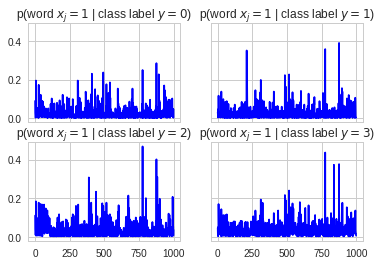

In [17]:
#generate plots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True)    
ax1.plot(np.arange(D), np.exp(log_pxy[0,:]), color='b')
ax1.set_title('p(word $x_j = 1$ | class label $y = 0$)')
ax2.plot(np.arange(D), np.exp(log_pxy[1,:]), color='b')
ax2.set_title('p(word $x_j = 1$ | class label $y = 1$)')    
ax3.plot(np.arange(D), np.exp(log_pxy[2,:]), color='b')
ax3.set_title('p(word $x_j = 1$ | class label $y = 2$)')    
ax4.plot(np.arange(D), np.exp(log_pxy[3,:]), color='b')
ax4.set_title('p(word $x_j = 1$ | class label $y = 3$)')    
f.savefig('./figures/naive_bayes_theta.png')


We can also visualize the class label distribution:

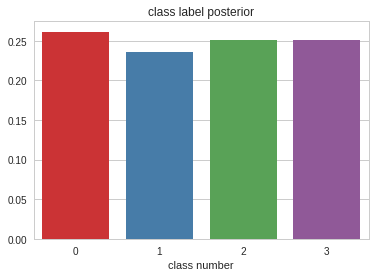

In [18]:
plt.figure()
sns.barplot(x=np.arange(C), y=np.exp(nb_clf.class_log_prior_), palette='Set1')
plt.title('class label posterior')
plt.xlabel('class number')
plt.savefig('./figures/naive_bayes_pi.png')

Finally, let's visualize the test document ranking based on entropy and mutual information:

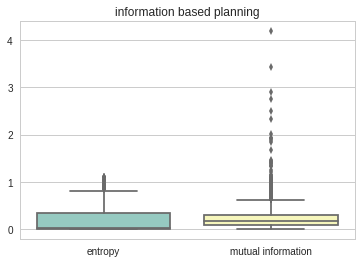

In [20]:
plt.figure()
sns.boxplot(x=['entropy', 'mutual information'], y=[X_test_class_entropy, X_test_docs_MI], palette="Set3")
plt.title('information based planning')
plt.savefig('./figures/naive_bayes_boxplot.png')

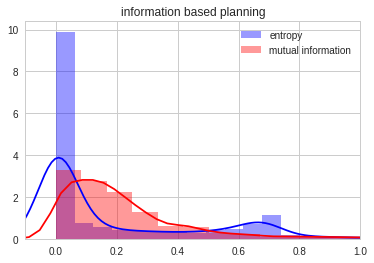

In [21]:
plt.figure()
sns.distplot(X_test_class_entropy, hist=True, kde=True, norm_hist=True, color='b', label='entropy')
sns.distplot(X_test_docs_MI, hist=True, kde=True, norm_hist=True, color='r', label='mutual information')
plt.title('information based planning')
plt.legend()
plt.xlim([-0.1,1])
plt.savefig('./figures/naive_bayes_hist.png')


In particular, we are interested in outliers, i.e. documents that have highest entropy and mutual information. From the box plot above, we can see a larger range of highest MI test documents compared to highest entropy documents, which suggests that MI could be better at differentiating which documents are most suitable for information planning. In order to verify this hypothesis and the utility of information measures, we want to compare information based planning against a random baseline and implement this notebook as part of an active learning pipeline.

### References

[1] B. Settles, "Active Learning Literature Survey", Technical Report, 2010  
[2] K. Chaloner and I. Verdinelli, "Bayesian Experimental Design: A Review", Statistical Science, 1995  
[3] T. Cover and J. Thomas, "Elements of Information Theory", Wiley, 2006  
[4] K. Murphy, "Machine Learning: A Probabilistic Perspective", MIT Press, 2012  
[5] F. Pedregosa et al. "Scikit-learn: Machine Learning in Python: http://scikit-learn.org/stable/", JMLR, 2011   